<a href="https://colab.research.google.com/github/TheAlchemist010/DeepLearning-Notebooks/blob/main/FIT3181/A1_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:#0b486b">  FIT3181: Deep Learning (2024)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **Prof Dinh Phung** | dinh.phung@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Lim Chern Hong** | lim.chernhong@monash.edu <br/>  <br/>
*Head Tutor 3181:*  **Miss Vy Vo** |  \[v.vo@monash.edu \] <br/>
*Head Tutor 5215:*  **Dr Van Nguyen** |  \[van.nguyen1@monash.edu \]

<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
***
Surname: **Gallagher**  <br/>
Firstname: **Daniel**    <br/>
Student ID: **33094969**    <br/>
Email: **dgal0013@student.monash.edu**    <br/>
Your tutorial time: **Monday 4-6PM**    <br/>
***

# <span style="color:#0b486b">Deep Neural Networks</span>
### Due: <span style="color:red">11:55pm Sunday, 8 September 2024</span>  (Sunday)

#### <span style="color:red">Important note:</span> This is an **individual** assignment. It contributes **25%** to your final mark. Read the assignment instructions carefully.

## <span style="color:#0b486b">Part 3: Convolutional Neural Networks and Image Classification</span>

**<div style="text-align: right"><span style="color:red">[Total marks for this part: 45 points]</span></div>**

The third part of this assignment is to demonstrate your basis knowledge in deep learning that you have acquired from the lectures and tutorials materials. Most of the contents in this assignment are drawn from **the tutorials covered from weeks 3 to 6**. Going through these materials before attempting this assignment is highly recommended.

**The dataset used for this part is a specific dataset for this unit consisting of approximately $10,000$ images of $20$ classes of Animals, each of which has approximately 500 images. You can download the dataset at [download here](https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link) if you want to do your assignment on your machine.**


In [2]:
!pip install gdown torch-summary

In [3]:
import os
import requests
import tarfile
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1234)

CUDA is available!  Training on GPU ...


Download the dataset to the folder of this Google Colab.

In [6]:
!gdown --fuzzy https://drive.google.com/file/d/1TzwS2ZcE1uyEfLLG1QIHS5M2B3AtwHUv/view?usp=sharing

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1TzwS2ZcE1uyEfLLG1QIHS5M2B3AtwHUv

but Gdown can't. Please check connections and permissions.


In [5]:
!gdown --fuzzy https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG

but Gdown can't. Please check connections and permissions.


We unzip the dataset to the folder.

In [4]:
!unzip -q Animals_Dataset.zip

unzip:  cannot find or open Animals_Dataset.zip, Animals_Dataset.zip.zip or Animals_Dataset.zip.ZIP.


In [6]:
data_dir = "../input/animals/FIT5215_Dataset"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Example of DataLoader creation for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Number of instance in train_set: %s" % len(train_dataset))
print("Number of instance in val_set: %s" % len(val_dataset))

Number of instance in train_set: 8519
Number of instance in val_set: 947


In [7]:
class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [9]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

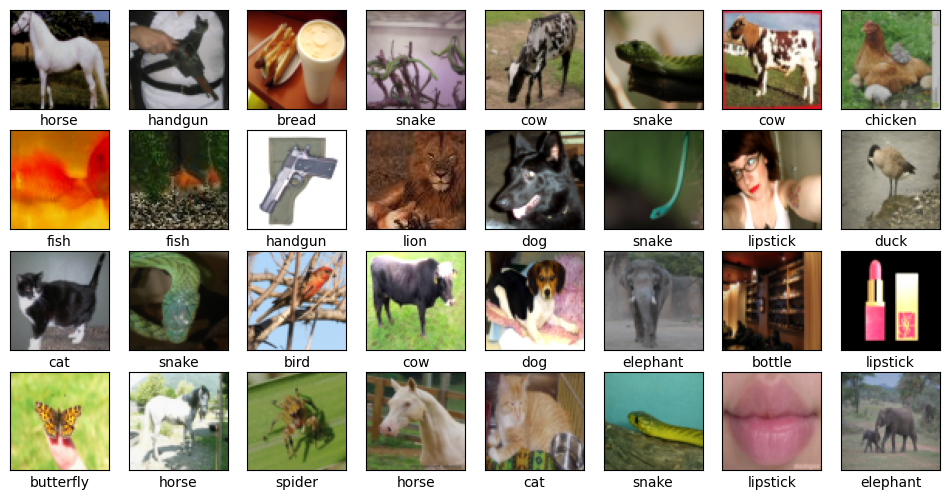

In [10]:
visualize_data(images, labels)

**For questions 3.1 to 3.7, you'll need to write your own model in a way that makes it easy for you to experiment with different architectures and parameters. The goal is to be able to pass the parameters to initialize a new instance of `YourModel` to build different network architectures with different parameters. Below are descriptions of some parameters for `YourModel`:**

1. `Block confirguration`: Our network consists of many blocks. Each block has the pattern `[conv, batch norm, activation, conv, batch norm, activation, max pool, dropout]`. All convolutional layers have filter size $(3, 3)$, strides $(1, 1)$ and padding = 1, and all max pool layers have strides $(2, 2)$, kernel size $2$, and padding = 0. The network will consists of a few blocks before applying a linear layer to output the logits for the softmax layer.

2. `list_feature_maps`: the number of feature maps in the blocks of the network. For example, if `list_feature_maps = [16, 32, 64]`, our network has three blocks with the input_channels or number of feature maps are `16, 32`, and `64` respectively.
3. `drop_rate`: the keep probability for dropout. Setting `drop_rate` to $0.0$ means not using dropout.
4. `batch_norm`: the batch normalization function is used or not. Setting `batch_norm` to `false` means not using batch normalization.
5. `use_skip`: the skip connection is used in the blocks or not. Setting this to `true` means that we use `1x1` Conv2D with `strides=2` for the skip connection.
6. At the end, you need to apply `global average pooling (GAP)` (`AdaptiveAvgPool2d((1, 1))`) to flatten the 3D output tensor before defining the output linear layer for predicting the labels.



Here is the model confirguration of `YourCNN` if the `list_feature_maps = [16, 32, 64]` and `batch_norm = true`.

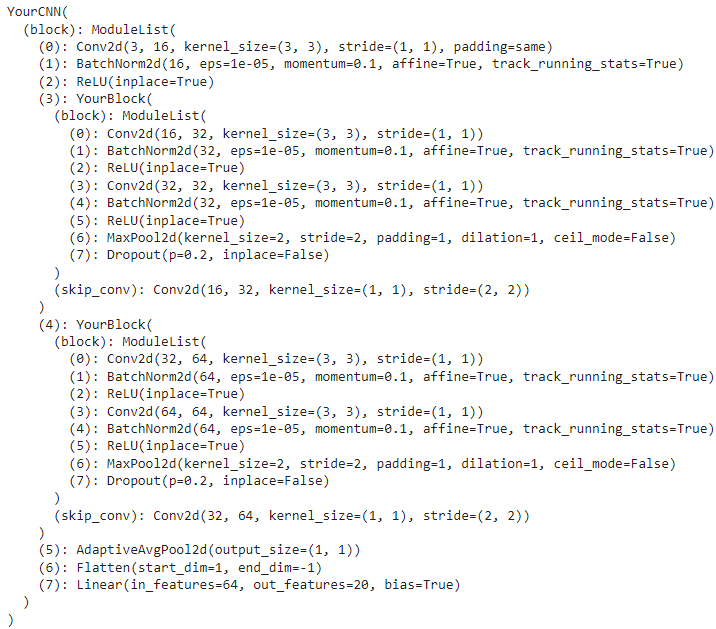

<span style="color:red">**Question 3.1:**</span> **You need to implement the aforementioned CNN**.

**First, you need to implement the block of our CNN in the class `YourBlock`. You can ignore `use_skip` and `skip connection` for simplicity. However, you cannot earn full marks for this question.**

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [15]:
class YourBlock(nn.Module):
  def __init__(self, in_feature_maps, out_feature_maps, drop_rate = 0.2, batch_norm = True, use_skip = True):
    super(YourBlock, self).__init__()
    self.use_skip = use_skip

    layers = []
    layers.append(nn.Conv2d(in_channels=in_feature_maps, out_channels=out_feature_maps, kernel_size=3, padding=1))

    if batch_norm:
      layers.append(nn.BatchNorm2d(out_feature_maps))

    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.Conv2d(in_channels=out_feature_maps, out_channels=out_feature_maps, kernel_size=3, padding=1))

    if batch_norm:
      layers.append(nn.BatchNorm2d(out_feature_maps))

    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    layers.append(nn.Dropout(drop_rate))

    self.convBlock = nn.Sequential(*layers)

    if use_skip:
        self.skip_conv = nn.Conv2d(in_channels=in_feature_maps, out_channels=out_feature_maps, kernel_size=1, stride=2)
    else:
        self.skip_conv = None


  def forward(self, x):
    out = self.convBlock(x)

    if self.use_skip:
        x = self.skip_conv(x)
        out += x

    return out


**Second, you need to use the above `YourBlock` to implement the class `YourCNN`**.

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [17]:
class YourCNN(nn.Module):
  def __init__(self, list_feature_maps = [16, 32, 64], drop_rate = 0.2, batch_norm= True, use_skip = True):
    super(YourCNN, self).__init__()
    self.layers = nn.ModuleList()

    self.layers.append(nn.Conv2d(in_channels=3, out_channels=list_feature_maps[0], kernel_size=3, padding="same"))

    if batch_norm:
      self.layers.append(nn.BatchNorm2d(num_features=list_feature_maps[0]))

    self.layers.append(nn.ReLU(inplace=True))

    for i in range(len(list_feature_maps)-1):
        self.layers.append(YourBlock(list_feature_maps[i], list_feature_maps[i+1], drop_rate, batch_norm, use_skip))

    self.layers.append(nn.AdaptiveAvgPool2d(output_size=(1,1)))
    self.layers.append(nn.Flatten(start_dim=1))
    self.layers.append(nn.Linear(in_features=list_feature_maps[-1], out_features=20, bias= True))

  def forward(self, x):
    for l in self.layers:
        x = l(x)
    return x



**We declare `my_cnn` from `YourCNN` as follows**.

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_cnn = YourCNN(list_feature_maps = [16, 32, 64], use_skip = True)
my_cnn = my_cnn.to(device)
print(my_cnn)

YourCNN(
  (layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): YourBlock(
      (convBlock): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Dropout(p=0.2, inplace=False)
      )
      (skip_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
    )
    (4): YourBlock(
      (convBlock): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride

**We declare the optimizer and the loss function.**

In [19]:
# Loss and optimizer
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=learning_rate)

**Here are the codes to compute the loss and accuracy.**

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

**Here is the code to train our model.**

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)
  # Move the model to the device before initializing the optimizer
  model.to(device) # Move the model to the GPU

  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:
      # Move input data to the same device as the model
      X,y = X.to(device), y.to(device)
      # Forward pass
      outputs = model(X.type(torch.float32)) # X is already on the correct device
      loss = loss_fn(outputs, y.type(torch.long))
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()
    #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    if not verbose: #verbose = True means we do show the training information during training
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

In [18]:
history = fit(model= my_cnn, train_loader=train_loader, valid_loader = val_loader, optimizer = optimizer, num_epochs= 10, verbose = False)

Epoch 1/10

train loss= 2.4588 - train acc= 25.01% - valid loss= 2.4485 - valid acc= 24.39%

Epoch 2/10

train loss= 2.0940 - train acc= 32.96% - valid loss= 2.1616 - valid acc= 29.88%

Epoch 3/10

train loss= 1.9295 - train acc= 38.71% - valid loss= 1.9747 - valid acc= 37.49%

Epoch 4/10

train loss= 1.7240 - train acc= 47.29% - valid loss= 1.7714 - valid acc= 45.51%

Epoch 5/10

train loss= 1.8524 - train acc= 42.85% - valid loss= 1.8996 - valid acc= 40.34%

Epoch 6/10

train loss= 1.6467 - train acc= 48.02% - valid loss= 1.7028 - valid acc= 46.99%

Epoch 7/10

train loss= 1.6426 - train acc= 49.02% - valid loss= 1.6757 - valid acc= 49.21%

Epoch 8/10

train loss= 1.4434 - train acc= 54.44% - valid loss= 1.4696 - valid acc= 52.48%

Epoch 9/10

train loss= 1.4337 - train acc= 54.67% - valid loss= 1.4872 - valid acc= 52.69%

Epoch 10/10

train loss= 1.4251 - train acc= 53.99% - valid loss= 1.5338 - valid acc= 50.79%


<span style="color:red">**Question 3.2:**</span> **Now, let us tune the number of blocks $use\_skip \in \{true,false\}$ and $learning\_rate \in \{0.001, 0.0005\}$. Write your code for this tuning and report the result of the best model on the testing set. Note that you need to show your code for tuning and evaluating on the test set to earn the full marks. During tuning, you can set the instance variable `verbose` of your model to `True` for not showing the training details of each epoch.**

Note that for this question, depending on your computational resource, you can choose `list_feature_maps= [32, 64]` or `list_feature_maps= [16, 32, 64]`.

<div style="text-align: right"> <span style="color:red">[3 points]</span> </div>

In [21]:
skips = [True, False]
lr = [0.001, 0.0005]

highest_acc = 0
best_model = None
best_params = None

for skip in skips:
  for rate in lr:
    my_cnn = YourCNN(list_feature_maps = [32, 64], use_skip = skip)
    my_cnn = my_cnn.to(device)
    optimizer = torch.optim.Adam(my_cnn.parameters(), lr=rate)

    history = fit(model= my_cnn, train_loader=train_loader, valid_loader = val_loader, optimizer = optimizer, num_epochs= 10, verbose = True)

    if history["val_acc"][-1] > highest_acc:
      highest_acc = history["val_acc"][-1]
      best_model = my_cnn
      best_params = {"skips" : skip, "learning rate" : rate}

print(best_params)

{'skips': True, 'learning rate': 0.001}


**Please note that you struggle in implementing the aforementioned CNN. You can use the MiniVGG network in our labs for doing the following questions. However, you cannot earn any mark for 3.1 and 3.2.**

<span style="color:red">**Question 3.3:**</span> **Exploring Data Mixup Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Data mixup is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mixup technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for data mixup [link for main paper](https://openreview.net/pdf?id=r1Ddp1-Rb) and a good article [article link](https://www.inference.vc/mixup-data-dependent-data-augmentation/).

You need to extend your model developed above, train a model using data mixup, and write your observations and comments about the result.

In [24]:
import numpy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit_data_mixup(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234, alpha = 0.2):
  torch.manual_seed(seed)
  # Move the model to the device before initializing the optimizer
  model.to(device) # Move the model to the GPU

  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (x1, y1) in train_loader:
      # Data Mixup
      lam = numpy.random.beta(alpha, alpha)
      indices = torch.randperm(x1.size(0))
      y1 = nn.functional.one_hot(y1, 20)
      x2, y2 = x1[indices], y1[indices] #Shuffle dataset

      X = (lam * x1 + (1. - lam) * x2)
      y = (lam * y1 + (1. - lam) * y2)

      # Move input data to the same device as the model
      X, y = X.to(device), y.to(device)

      # Forward pass
      outputs = model(X.type(torch.float32)) # X is already on the correct device
      loss = loss_fn(outputs, y)
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()
    #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    if not verbose: #verbose = True means we do show the training information during training
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history



In [25]:
my_cnn = YourCNN(list_feature_maps = [16, 32, 64], use_skip = True)
my_cnn = my_cnn.to(device)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=learning_rate)

history = fit_data_mixup(model= my_cnn, train_loader=train_loader, valid_loader = val_loader, optimizer = optimizer, num_epochs= 10, verbose = False)

Epoch 1/10
train loss= 2.3267 - train acc= 28.01% - valid loss= 2.3421 - valid acc= 25.87%
Epoch 2/10
train loss= 2.1217 - train acc= 35.00% - valid loss= 2.1399 - valid acc= 34.42%
Epoch 3/10
train loss= 2.0295 - train acc= 35.79% - valid loss= 2.0963 - valid acc= 32.31%
Epoch 4/10
train loss= 1.7664 - train acc= 46.37% - valid loss= 1.8159 - valid acc= 40.65%
Epoch 5/10
train loss= 1.7707 - train acc= 44.54% - valid loss= 1.7854 - valid acc= 44.46%
Epoch 6/10
train loss= 1.6724 - train acc= 49.07% - valid loss= 1.7031 - valid acc= 46.78%
Epoch 7/10
train loss= 1.7215 - train acc= 44.43% - valid loss= 1.8136 - valid acc= 42.77%
Epoch 8/10
train loss= 1.5639 - train acc= 51.39% - valid loss= 1.6111 - valid acc= 50.26%
Epoch 9/10
train loss= 1.5311 - train acc= 52.49% - valid loss= 1.5968 - valid acc= 51.64%
Epoch 10/10
train loss= 1.5205 - train acc= 51.44% - valid loss= 1.6140 - valid acc= 49.31%


The data mixup training resulted in a model with a similar accuracy on both the training and test dataset. It is likely that if both models were trained for more epochs, the data mixup model would outperform the standard model on the test dataset.

<span style="color:red">**Question 3.4:**</span> **Exploring CutMix Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Data mixup is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mixup technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for Cutmix [link for main paper](https://arxiv.org/pdf/1905.04899v2) and a good article [article link](https://shorturl.at/TNwjv).

You need to extend your model developed above, train a model using data mixup, and write your observations and comments about the result.

In [34]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    rw = int(W * cut_rat)
    rh = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - rw // 2, 0, W)
    bby1 = np.clip(cy - rh // 2, 0, H)
    bbx2 = np.clip(cx + rw // 2, 0, W)
    bby2 = np.clip(cy + rh // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [53]:
def cutmix(x1,y1,alpha):       
    lam = numpy.random.beta(alpha, alpha)
    indices = torch.randperm(x1.size(0))
    y1 = nn.functional.one_hot(y1, 20)
    x2, y2 = x1[indices], y1[indices] #Shuffle dataset
    
    y = (lam * y1 + (1. - lam) * y2)
    
    bbx1, bby1, bbx2, bby2 = rand_bbox([x1.size(2),x1.size(3)], lam)
   
    X = x1.clone().detach()
    X[:, bbx1:bbx2, bby1:bby2] = x2[:, bbx1:bbx2, bby1:bby2]
    return X, y

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit_cutmix(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)
  # Move the model to the device before initializing the optimizer
  model.to(device) # Move the model to the GPU

  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:
      # Move input data to the same device as the model
      X,y = X.to(device), y.to(device)
      X,y = cutmix(X,y,0.2)
      # Forward pass
      outputs = model(X.type(torch.float32)) # X is already on the correct device
      loss = loss_fn(outputs, y)
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()
    #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    if not verbose: #verbose = True means we do show the training information during training
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

In [54]:
my_cnn = YourCNN(list_feature_maps = [16, 32, 64], use_skip = True)
my_cnn = my_cnn.to(device)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=learning_rate)

history = fit_cutmix(model= my_cnn, train_loader=train_loader, valid_loader = val_loader, optimizer = optimizer, num_epochs= 10, verbose = False)

Epoch 1/10
train loss= 2.4979 - train acc= 23.21% - valid loss= 2.5376 - valid acc= 23.13%
Epoch 2/10
train loss= 2.3662 - train acc= 28.44% - valid loss= 2.4022 - valid acc= 28.30%
Epoch 3/10
train loss= 2.2612 - train acc= 32.13% - valid loss= 2.2827 - valid acc= 29.99%
Epoch 4/10
train loss= 2.1560 - train acc= 37.35% - valid loss= 2.1990 - valid acc= 34.11%
Epoch 5/10
train loss= 2.1410 - train acc= 40.00% - valid loss= 2.1644 - valid acc= 39.28%
Epoch 6/10
train loss= 2.2852 - train acc= 33.27% - valid loss= 2.3162 - valid acc= 32.63%
Epoch 7/10
train loss= 2.0096 - train acc= 42.46% - valid loss= 2.0474 - valid acc= 43.08%
Epoch 8/10
train loss= 1.9127 - train acc= 45.93% - valid loss= 1.9528 - valid acc= 43.61%
Epoch 9/10
train loss= 1.9329 - train acc= 43.80% - valid loss= 1.9523 - valid acc= 43.82%
Epoch 10/10
train loss= 1.9797 - train acc= 39.97% - valid loss= 2.0091 - valid acc= 39.28%


The CutMix training resulted in a less effective model than the standard training did after 10 epochs. Perhaps given longer training, the CutMix would outperform the standard model. It also might have not been implemented correctly, as it seems not to be improving very much.

<span style="color:red">**Question 3.5:**</span> Implement the **one-versus-all (OVA)** loss. The details are as follows:
- You need to apply `the sigmoid activation function` to logits $h = [h_1, h_2,...,h_M]$ instead of `the softmax activation` function as usual to obtain $p = [p_1, p_2,...,p_M]$, meaning that $p_i = sigmoid(h_i), i=1,...,M$. Note that $M$ is the number of classes.
- Given a data example $x$ with the ground-truth label $y$, the idea is to maximize the likelihood $p_y$ and to minimize the likelihoods $p_i, i \neq y$. Therefore, the objective function is to find the model parameters to
  - $\max\left\{ \log p_{y}+\sum_{i\neq y}\log(1-p_{i})\right\}$ or equivalently $\min\left\{ -\log p_{y}-\sum_{i\neq y}\log(1-p_{i})\right\}$.
  - For example, if $M=3$ and $y=2$, you need to minimize $\min\left\{ -\log(1-p_{1})-\log p_{2}-\log(1-p_{3})\right\}$.

Compare the model trained with the OVA loss and the same model trained with the standard cross-entropy loss.

<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>



In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit_OVA(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)
  loss_fn = nn.BCEWithLogitsLoss()
  # Move the model to the device before initializing the optimizer
  model.to(device) # Move the model to the GPU

  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:
      # Move input data to the same device as the model
      y = nn.functional.one_hot(y, 20)
      X,y = X.to(device), y.to(device)
      # Forward pass
      outputs = model(X.type(torch.float32)) # X is already on the correct device
      loss = loss_fn(outputs, y.type(torch.float32))
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()
    #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    if not verbose: #verbose = True means we do show the training information during training
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      batchY = torch.eye(20)[batchY].to(device)
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.float32)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [ ]:
my_cnn = YourCNN(list_feature_maps = [16, 32, 64], use_skip = True)
my_cnn = my_cnn.to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=learning_rate)

history = fit_OVA(model= my_cnn, train_loader=train_loader, valid_loader = val_loader, optimizer = optimizer, num_epochs= 40, verbose = False)

Epoch 1/40
train loss= 0.1638 - train acc= 28.98% - valid loss= 0.1639 - valid acc= 28.83%
Epoch 2/40
train loss= 0.1550 - train acc= 31.80% - valid loss= 0.1581 - valid acc= 28.41%
Epoch 3/40
train loss= 0.1449 - train acc= 37.74% - valid loss= 0.1467 - valid acc= 36.33%
Epoch 4/40
train loss= 0.1386 - train acc= 43.88% - valid loss= 0.1404 - valid acc= 42.56%
Epoch 5/40
train loss= 0.1366 - train acc= 43.78% - valid loss= 0.1389 - valid acc= 40.34%
Epoch 6/40
train loss= 0.1774 - train acc= 33.29% - valid loss= 0.1753 - valid acc= 32.10%
Epoch 7/40
train loss= 0.1309 - train acc= 48.29% - valid loss= 0.1339 - valid acc= 46.15%
Epoch 8/40
train loss= 0.1181 - train acc= 53.93% - valid loss= 0.1181 - valid acc= 53.33%
Epoch 9/40
train loss= 0.1166 - train acc= 53.45% - valid loss= 0.1203 - valid acc= 49.63%
Epoch 10/40
train loss= 0.1198 - train acc= 51.32% - valid loss= 0.1241 - valid acc= 49.42%
Epoch 11/40
train loss= 0.1123 - train acc= 57.21% - valid loss= 0.1166 - valid acc= 53.7

<span style="color:red">**Question 3.6:**</span> **Attack your best obtained model with PGD attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the testing set. Write the code for the attacks and report the robust accuracies. Also choose a random set of 20 clean images in the testing set and visualize the original and attacked images.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

In [106]:
def pgd_attack(model, train_loader, epsilon=0.3, eta=0.01, k=20):
    model.to(device)
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    
    adv_examples = []
    original_images = []

    for (X, y) in train_loader:
        X,y = X.to(device), y.to(device)
        X.requires_grad = True
        
        X_original = X.clone().detach()

        for _ in range(k):
            # Forward
            output = model(X.type(torch.float32))
            loss = loss_fn(output, y)
            
            model.zero_grad()
            
            # Backward
            loss.backward()
            
            # Aadversarial example
            X_adv = X + (eta * X.grad.sign())
            
            # Project the data
            perturbation = torch.clamp(X_adv - X_original, min=-epsilon, max=epsilon)
            X = torch.clamp(X_original + perturbation, 0, 1).detach_()
            X.requires_grad = True

            
        adv_examples.append(X.detach().cpu())
        original_images.append(X_original.cpu())
        
    return original_images, adv_examples


In [164]:
def pgd_attack(model, input_image, epsilon=0.3, eta=0.01, k=20):
    model.eval()
    input_image = input_image.unsqueeze(0)
    adv_image = input_image.clone().detach().requires_grad_(True)
    loss_fn = nn.CrossEntropyLoss()
    
    random_noise = torch.FloatTensor(input_image.shape).uniform_(-epsilon, epsilon)
    adv_image = adv_image + random_noise
    adv_image = torch.clamp(adv_image, 0, 1.0).detach().requires_grad_(True)
    
    adv_image, input_image = adv_image.to(device), input_image.to(device)
    output = model(adv_image)
    
    input_label = output.argmax(dim=1)
    
    for _ in range(k):
        adv_image.requires_grad_(True)
        adv_image.retain_grad()
        output = model(adv_image)
        loss = loss_fn(output, input_label)
        model.zero_grad()
        loss.backward()
        
        
        gradient = adv_image.grad.data
        adv_image = adv_image + eta * gradient.sign()
        adv_image = torch.clamp(adv_image, input_image + epsilon, input_image - epsilon)
        adv_image = adv_image.detach()
        
    adv_image = adv_image.squeeze(0)
    return adv_image.detach().cpu()

In [198]:
def visualize_attack(images, categories, images_per_row = 8):
    class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(2*images_per_row, 3*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        pred_label = my_cnn(torch.from_numpy(images[i]).unsqueeze(0).to(device)).argmax(dim=1)[0].item()
        plt.xlabel("Real Label: " + class_names[class_index] + "\nPred Label: " + class_names[pred_label])
    plt.show()
    
    fig = plt.figure(figsize=(2*images_per_row, 2*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        attacked_image = pgd_attack(my_cnn, torch.from_numpy(images[i]))
        imshow(attacked_image)
        class_index = categories[i]
        pred_label = my_cnn(attacked_image.unsqueeze(0).to(device)).argmax(dim=1)[0].item()
        plt.xlabel("Real Label: " + class_names[class_index] + "\nPred Label (After Attack): " + class_names[pred_label])
    plt.show()

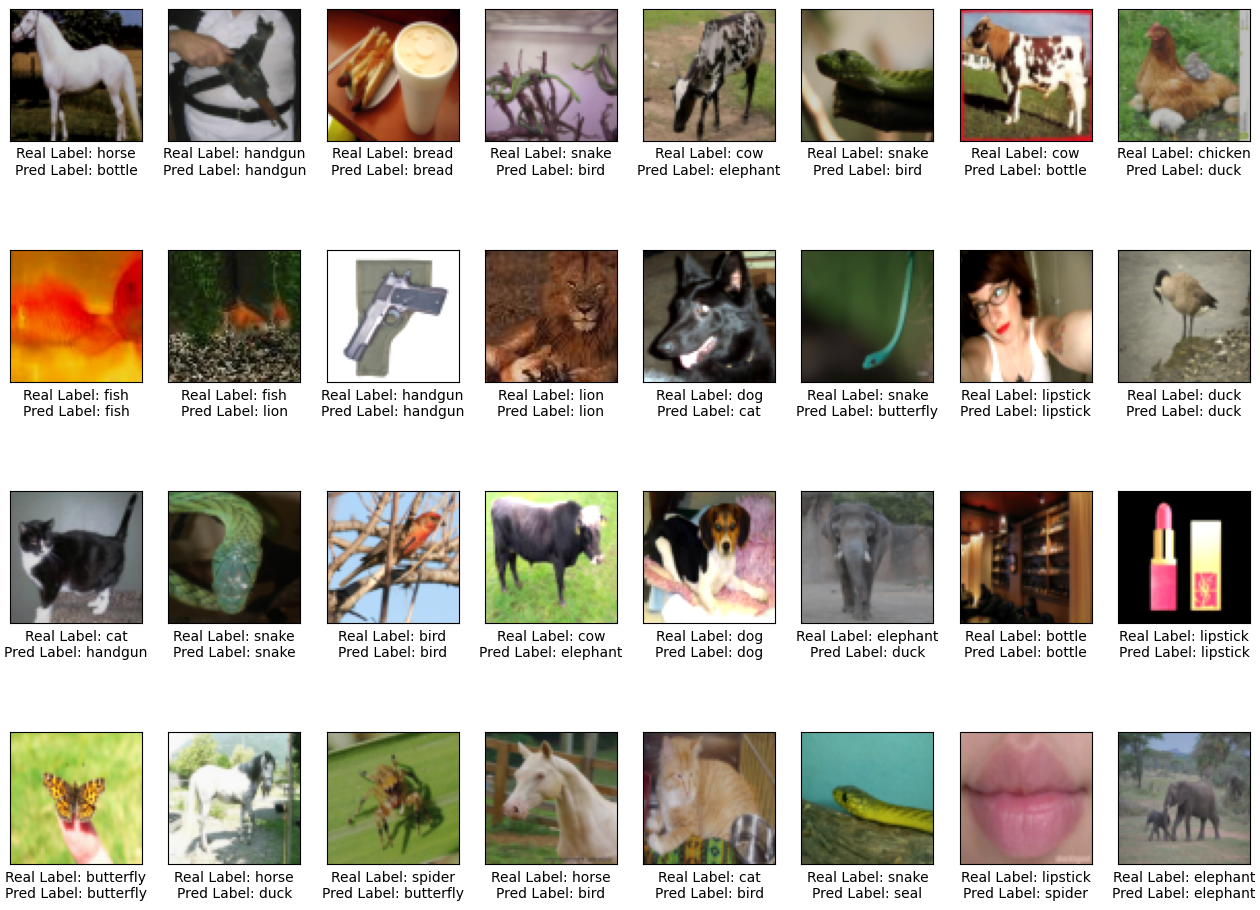

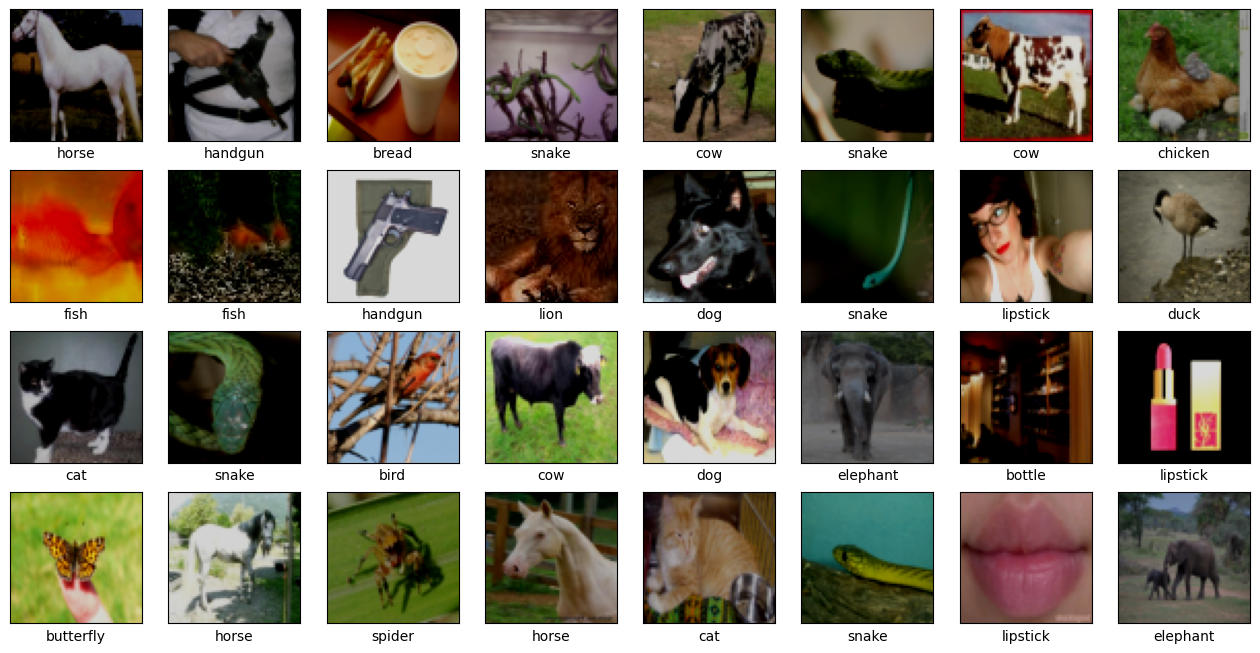

In [199]:
visualize_attack(images, labels)

<span style="color:red">**Question 3.7:**</span> **Train a robust model using adversarial training with PGD ${\epsilon= 0.0313, k=10, \eta= 0.002}$. Write the code for the adversarial training and report the robust accuracies. After finishing the training, you need to store your best robust model in the folder `./models` and load the model to evaluate the robust accuracies for PGD and FGSM attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the testing set.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

<span style="color:red">**Question 3.8 (Kaggle competition)**</span>
<div style="text-align: right"> <span style="color:red">[10 points]</span> </div10

You can reuse the best model obtained in this assignment or develop new models to evaluate on the **testing set of the FIT3181/5215 Kaggle competion**. However, to gain any points for this question, your testing accuracy must **exceed** the accuracy threshold from a base model developed by us as shown in the leader board of the competition.

The marks for this question are as follows:
- If you are in *top 10%* of your cohort, you gain *10 points*.
- If you are in *top 20%* of your cohort, you gain *8 points*.
- If you are in *top 30%* of your cohort, you gain *6 points*.
- If you *beat* our base model, you gain *4 points*.

---
**<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>**
**<div style="text-align: center"> <span style="color:black">GOOD LUCK WITH YOUR ASSIGNMENT 1!</span> </div>**